In [1]:
from utils.converters import df_to_XY
from utils.readers import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tools as smt
import statsmodels.stats.descriptivestats as std

## Read data
## Grouping M&A volume by month

In [2]:
def reconfigure_vol_df(df):
    df['Date'] = df['Date'].dt.to_period('M')
    out = {'date': [], 'vol': []}
    for y in range(2000, 2022):
        for m in range(1, 13):
            i = f"{y}-{m}"
            d = df[df['Date'] == i]
            out['date'].append(i)
            out['vol'].append(len(d))
    df = pd.DataFrame(data=out['vol'], index=out['date'], columns=['vol'])
    df.index.name = 'date'
    return df

In [3]:
"""Groups M&A transactions of UK being the acquirer by month"""
acquirer_uk = read_acquirer_uk()
acquirer_uk = reconfigure_vol_df(acquirer_uk)

In [4]:
"""Groups M&A transactions of UK being the target by month"""
target_uk= read_target_uk()
target_uk = reconfigure_vol_df(target_uk)

In [5]:
"""Net M&A volume"""
net_vol_monthly = target_uk + acquirer_uk

In [6]:
# net_vol_monthly.index.values.astype(str)

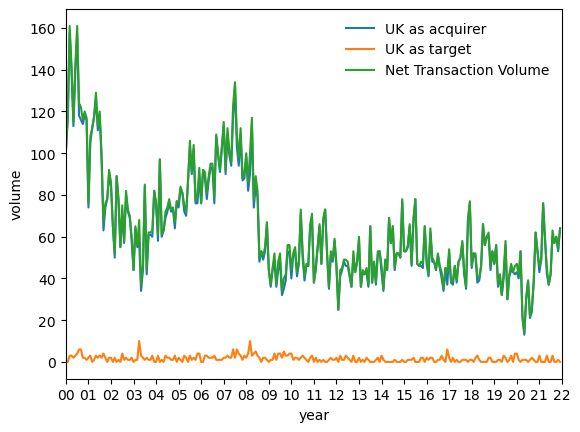

In [7]:
ax = plt.gca()
ax.plot(acquirer_uk.index.values.astype(str), acquirer_uk.vol, label='UK as acquirer')
ax.plot(target_uk.index.values.astype(str), target_uk.vol, label='UK as target')
ax.plot(net_vol_monthly.index.values.astype(str), net_vol_monthly.vol, label='Net Transaction Volume')
ax.set_xticks([])
ax.legend(frameon=False)
ax.set_xticks(ticks=range(0, 265, 12), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
ax.set_xlim(0, 264)
ax.set_ylabel('volume')
ax.set_xlabel('year');

## GDP

## Only quarterly data available

In [8]:
gdp_quarter = read_gdp()
until = '2022-01'
gdp_quarter['Date'] = gdp_quarter['Date'].dt.to_period('M')
gdp_quarter = gdp_quarter[gdp_quarter['Date'] < until]
# gdp_quarter

In [9]:
"""Regrouping transactions by cumulative of 3 months and quarterly data of other explanatory variables: SMI, EXUSUK, and SMI."""
res = []
for i in range(int(len(net_vol_monthly)/3)):
    s = net_vol_monthly[3*i: 3*(i+1)]
    res.append(s.vol.sum())
gdp_quarter['vol'] = res
# gdp_quarter

## Variables

In [10]:
until = '2022-01'
var_monthly = read_variable_monthly()
interest_rate = read_interest_rate()
interest_rate['Date'] = interest_rate['Date'].dt.to_period('M')
var_monthly['Date'] = var_monthly['Date'].dt.to_period('M')
var_monthly = var_monthly[var_monthly['Date'] < until]
interest_rate = interest_rate[interest_rate['Date'] < until]
var_monthly['vol'] = net_vol_monthly.vol.values
var_monthly['Interest_Rate'] = interest_rate['Interest_Rate']

res = {'EXUSUK': [], 'Interest_Rate': [], 'SMI': []}
for i in range(int(len(var_monthly)/3)):
    s = var_monthly[3*i: 3*(i+1)]
    res['EXUSUK'].append(s.EXUSUK.mean())
    res['Interest_Rate'].append(s['Interest_Rate'].mean())
    res['SMI'].append(s.SMI.mean())
gdp_quarter['EXUSUK'] = res['EXUSUK']
gdp_quarter['Interest_Rate'] = res['Interest_Rate']
gdp_quarter['SMI'] = res['SMI']
# gdp_quarter
# var_monthly

# Main Regression (Before Brexit)

In [11]:
"""To determine the effect the Brexit, we refer to the day of UK announcing its plan to exit the European Union as the separation date"""

x_index = ['EXUSUK', 'Interest_Rate', 'SMI']
y_index = ['vol']

start_from = '2002-01'
data = var_monthly[var_monthly.Date >= start_from]
data.reset_index(inplace=True, drop=True)
sep = '2016-6'
data_before = data[data.Date < sep]
data_after = data[data.Date > sep]

"""Regressing on historical transactions between Aug.2001 to June.2016"""
X_train, Y_train = df_to_XY(data_before, xkeys=x_index, ykeys=y_index)
X_train = sm.add_constant(X_train)

"""Regressing on historical transactions between June.2016 to Nov.2021"""
X_test, Y_test = df_to_XY(data_after, xkeys=x_index, ykeys=y_index)
X_test = sm.add_constant(X_test)

model_before = LinearRegression().fit(X_train, Y_train)
model_after = LinearRegression().fit(X_test, Y_test)

"""R square of model before and after the announcement of Brexit"""
model_before.score(X_train, Y_train), model_after.score(X_test, Y_test)

(0.617764976094516, 0.2318908533369991)

In [12]:
model_before.coef_

array([[ 0.        , 22.12368281,  9.46650448,  0.03523657]])

In [13]:
data

,Date,EXUSUK,Interest_Rate,SMI,vol
0,2002-01,1.4322,4.9171,962.025,86
1,2002-02,1.4227,4.9251,924.759,65
2,2002-03,1.4230,5.2202,927.846,52
3,2002-04,1.4429,5.2331,959.587,89
4,2002-05,1.4598,5.2689,946.755,78
...,...,...,...,...,...
235,2021-08,1.3797,0.6440,1154.280,63
236,2021-09,1.3732,0.8023,1150.933,57
237,2021-10,1.3701,1.0830,1113.011,60
238,2021-11,1.3463,0.9394,1167.690,54


In [14]:
new_T = pd.DataFrame(var_monthly.EXUSUK)
new_T['smi'] = var_monthly.SMI
new_T['spot'] = var_monthly.Interest_Rate
t_corr = new_T.corr(method='pearson')
t_corr



,EXUSUK,smi,spot
EXUSUK,1.000000,0.504034,0.699603
smi,0.504034,1.000000,0.086093
spot,0.699603,0.086093,1.000000


To evaluate the influence of Brexit, which happened in June of 2016, we divide the historical dataset into two parts by the event of Brexit: `X_train` and `X_text` for variables, and `Y_train` and `Y_test` for M&A volume, respectively. For each dataset, the OLS is adopted to build the model. In other words, the model before Brexit, named `model_before` is trained by the dateset before 2016 June, i.e., `X_train`. Hence, the use of the trained model (`model_before`) with the given `X_test` yields its own prediction, called `Y_test_pred_model_before`,  that is assumed without the influence of Brexit. Finally, calculating the percentage error between `Y_test_pred_model_before` and `Y_test` is able to tell us how much the M&A volume is influenced by Brexit.

Of course, since we have `X_text` and `Y_test`, we are also able to run the OLS on it. Consequently, the model, called `model_after` is introduced, which should have the error mean close to zero by the OLS definition. Then we expect to see that the percentage error should be close to zero as well.

The cell below reconfigure the data to be able to process by the OLS. Also, the figure shows the OLS model, compared to the data.

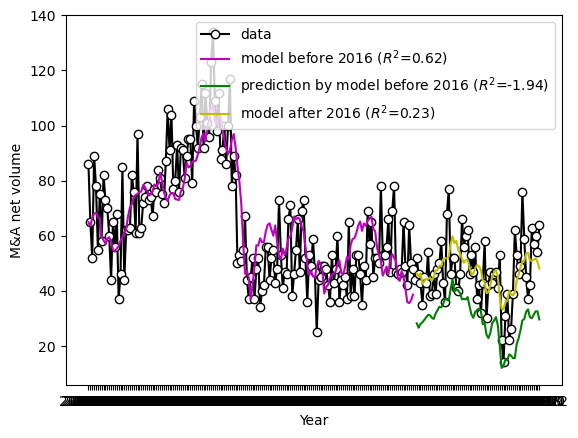

In [15]:
ax = plt.gca()

x_data = data.Date.astype(str)
ax.plot(x_data, data.vol, marker='o', color='k', mfc='white', ls='-', label='data')

Y_train_pred = model_before.predict(X_train)
x_data_before = data_before.index
r = r2_score(Y_train, Y_train_pred,)
ax.plot(x_data_before, Y_train_pred, color='m',
        label=f'model before 2016 ($R^2$={round(r, 2)})')

x_data_after = data_after.index
Y_test_pred = model_before.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='g',
        label=f'prediction by model before 2016 ($R^2$={round(r, 2)})')


"""Using model based on data before June.2016 to predict for 2016 - 2021"""
Y_test_pred = model_after.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='y',
        label=f'model after 2016 ($R^2$={round(r, 2)})')

# ax.axvline(65, ls='--', color='gray')
# plt.xticks(ticks=range(0, 89, 4), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
# ax.set_xlim(0, 88)
ax.set_ylabel('M&A net volume')
ax.set_xlabel('Year')
# ax.set_ylim(0, -500)
ax.legend(loc=0, frameon=True);

In [16]:
## Forecasting with different confidence intervals (alpha=0.5)
# def ols_quantile(m, X, q):
#   # m: OLS model.
#   # X: X matrix.
#   # q: Quantile.
#   # Set alpha based on q.
#   a = q * 2
#   if q > 0.5:
#     a = 2*(1 - q)
#     predictions = m.get_prediction(X)
#     frame = predictions.summary_frame(alpha=a)
#   if q > 0.5:
#     return frame.obs_ci_upper
#   return frame.obs_ci_lower

Instead of using the mean square error, we simply use the percentage error given as

$$
\text{ER} = \frac{Y_{test} - \hat{Y}_{test}^{before}}{Y_{test}}.
$$
This way we can learn the direction of the prediction, either over-estimation or under-estimation.

In [17]:
Y_test_pred_model_before = model_before.predict(X_test)
Y_test_pred_model_after = model_after.predict(X_test)

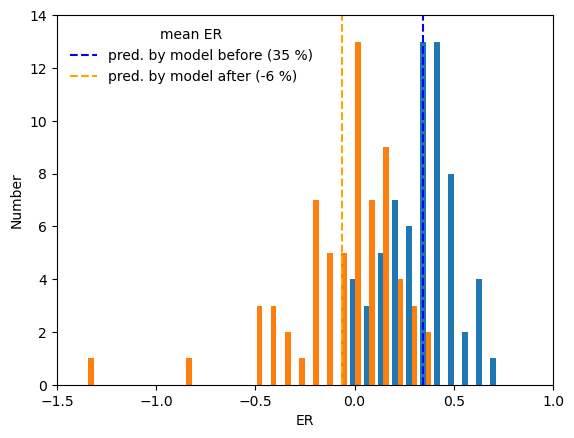

In [18]:
error_test_model_before = (Y_test - Y_test_pred_model_before) / Y_test
error_test_model_after = (Y_test - Y_test_pred_model_after) / Y_test
ax = plt.gca()

ax.hist([error_test_model_before.reshape(-1), error_test_model_after.reshape(-1)], bins=30)
ax.axvline(error_test_model_before.mean(), color='b', ls='--',
           label=f'pred. by model before ({round(error_test_model_before.mean()*100)} %)')
ax.axvline(error_test_model_after.mean(), color='orange', ls='--',
           label=f'pred. by model after ({round(error_test_model_after.mean()*100)} %)')

ax.set_xlabel('ER')
ax.set_ylabel('Number')
ax.set_xlim(-1.5, 1)
ax.set_ylim(0, 14)
ax.legend(frameon=False, title='mean ER')

The figure above shows that the `model_before` underestimated the M&A volume by 35%. it alternatively says that Brexit increased the M&A volume from within UK to overseas by 35%. This is primarily because that the number of foreign companies using direct investment was so small that it was negligible.

In [19]:
mse_model_before = smt.eval_measures.mse(Y_test, Y_test_pred)
mse_model_before
mse_model_after = smt.eval_measures.mse(Y_test, Y_test_pred_model_after)
mse_model_after
# var_monthly

array([110.11821506])

## Model before announcement of Brexit

In [20]:
"""Summary of model based on historical data before 2016"""
multi_model_before = sm.OLS(Y_train, X_train).fit()
multi_model_before.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     91.05
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           4.19e-35
Time:                        11:29:44   Log-Likelihood:                -694.33
No. Observations:                 173   AIC:                             1397.
Df Residuals:                     169   BIC:                             1409.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -47.2305     12.210     -3.868      0.000     -71.334     -23.127
Spot_Rate        22.1237     12.956      1.708      0.090      -3.453      47.700
Interest_Rate     9.4665      1.425      6.641      0.000       6.653      12.280
SMI               0.0352      0.008      4.617      0.000       0.020       0.050
==============================================================================
Omnibus:                        2.102   Durbin-Watson:                   1.415
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.808
Skew:                           0.126   Prob(JB):                        0.405
Kurtosis:                       2.567   Cond. No.                     1.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
## Forecast with alpha=0.5
pred = multi_model_before.get_prediction(X_test)
summary_table = pred.summary_frame(alpha=0.5)
summary_table

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,28.219499,2.814087,26.317333,30.121664,18.866370,37.572628
1,26.610696,2.926023,24.632868,28.588525,17.241887,35.979506
2,28.007621,2.903372,26.045103,29.970138,18.642031,37.373210
3,28.599108,3.470445,26.253280,30.944935,19.145765,38.052451
4,29.445693,3.213949,27.273243,31.618144,20.033875,38.857512
...,...,...,...,...,...,...
61,30.062860,2.856066,28.132319,31.993401,20.703919,39.421801
62,31.299667,2.777823,29.422014,33.177320,21.951492,40.647842
63,32.552090,2.602133,30.793193,34.310987,23.227043,41.877137
64,32.592857,2.884320,30.643218,34.542496,23.229958,41.955756


In [40]:
multi_model_before.get_prediction(X_test)
diff = summary_table.obs_ci_lower - summary_table.mean_ci_lower
diff2 = summary_table.mean_ci_upper - summary_table.obs_ci_upper
diff

0    -7.450963
1    -7.390981
2    -7.403072
3    -7.107516
4    -7.239368
        ...   
61   -7.428400
62   -7.470521
63   -7.566150
64   -7.413260
65   -7.414960
Length: 66, dtype: float64

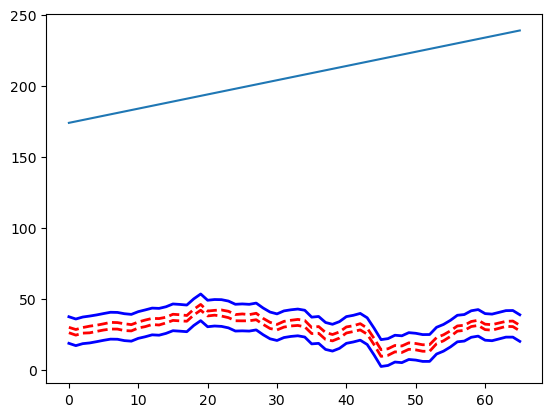

In [41]:
mean_upper = summary_table.mean_ci_upper
mean_lower = summary_table.mean_ci_lower
fitted_upper = summary_table.obs_ci_upper
fitted_lower = summary_table.obs_ci_lower
plt.plot(mean_upper, 'r--', lw=2)
plt.plot(mean_lower,'r--', lw=2)
plt.plot(fitted_upper, '-', lw=2, color='blue')
plt.plot(fitted_lower, '-', lw=2, color='blue')
plt.plot(x_data_after)

In [ ]:
fig_before1 = sm.graphics.plot_regress_exog(multi_model_before, 1)

In [ ]:
fig_before2 = sm.graphics.plot_regress_exog(multi_model_before, 2)

In [ ]:
fig_before3 = sm.graphics.plot_regress_exog(multi_model_before, 3)

In [ ]:
print(multi_model_before.summary())
# ['EXUSUK', 'Interest_Rate', 'SMI']

In [ ]:
# sm.add_constant(X_train)

In [ ]:
# multi_model_before.model.exog

In [ ]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name, test)

In [ ]:
VIF = [variance_inflation_factor(multi_model_before.model.exog, i) for i in range(1,4)]
VIF_data = pd.DataFrame(VIF, columns=['VIF'])
VIF_data.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data

## Model after announcement of Brexit

In [ ]:
multi_model_after = sm.OLS(Y_test, X_test).fit()
multi_model_after.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI'])

In [ ]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""

name_after = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_after = sms.het_breuschpagan(multi_model_after.resid, multi_model_after.model.exog)
lzip(name_after, test_after)

In [ ]:
VIF_after = [variance_inflation_factor(multi_model_after.model.exog, i) for i in range(1,4)]
VIF_data_after = pd.DataFrame(VIF_after, columns=['VIF'])
VIF_data_after.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_after

In [ ]:
fig_after1 = sm.graphics.plot_regress_exog(multi_model_after, 1)

In [ ]:
fig_after2 = sm.graphics.plot_regress_exog(multi_model_after, 2)

In [ ]:
fig_after3 = sm.graphics.plot_regress_exog(multi_model_after, 3)

## Overall Model from 2002 to 2021

In [ ]:
X_all, Y_all = df_to_XY(gdp_quarter, xkeys=x_index, ykeys=y_index)
X_all = sm.add_constant(X_all)
overall_model_ols = sm.OLS(Y_all, X_all).fit()
overall_model_ols.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI'])

In [ ]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(overall_model_ols.resid, overall_model_ols.model.exog)
lzip(name, test)

In [ ]:
VIF_overall = [variance_inflation_factor(overall_model_ols.model.exog, i) for i in range(1,4)]
VIF_data_over = pd.DataFrame(VIF_overall, columns=['VIF'])
VIF_data_over.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_over

In [ ]:
fig_overall1 = sm.graphics.plot_regress_exog(overall_model_ols, 1)

In [ ]:
fig_overall2 = sm.graphics.plot_regress_exog(overall_model_ols, 2)

In [ ]:
fig_overall3 = sm.graphics.plot_regress_exog(overall_model_ols, 3)

In [ ]:
print(overall_model_ols.summary())
# ['EXUSUK', 'Interest_Rate', 'SMI']